# Cleaning anomalies in time series per region slug



## Load  libraries

In [2]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import yaml
import matplotlib.pyplot as plt 
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# Plotting
import plotly
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format
p9.theme_set(p9.theme_linedraw()) # default theme

# Setting cufflinks
import textwrap
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import yaml
from jinja2 import Template
cf.themes.THEMES['custom'] = yaml.load(open('cufflinks_template.yaml', 'r'))

# Manipulation 
from siuba import *

# Outliers
from adtk.data import validate_series
from adtk.transformer import DoubleRollingAggregate
from adtk.visualization import plot
from adtk.pipe import Pipeline
from adtk.detector import QuantileAD
from adtk.transformer import ClassicSeasonalDecomposition

## Load data

### dahsboard data

In [160]:
from src import utils

conn = utils.connect_athena(path='../configs/athena.yaml')
df = pd.read_sql_query("""
select 
    *,
    date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
from spd_sdv_waze_corona.prod_daily_daily_index
where region_slug in ('country_mexico', 'country_brazil', 
    'mexicocity', 'riodejaneiro', 'saopaulo', 'torreon')
""", conn)

In [4]:
df.head(3)

,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,year,month,day,dow,observed,expected_2020,ratio_20,tcp,dashboard,region_shapefile_wkt,date
0,2021-03-16 10:52:56.713,country_brazil,Brasil,Brazil,BR,BR,country,212559409,,2020,9,22,2,1445446836,1.140203e+09,1.267710,26.770988,TRUE,"MULTIPOLYGON (((-73.983063 -7.534734,-73.95117...",2020-09-22
1,2021-03-16 10:52:56.713,country_brazil,Brasil,Brazil,BR,BR,country,212559409,,2020,12,8,2,1472740163,1.140203e+09,1.291647,29.164712,TRUE,"MULTIPOLYGON (((-73.983063 -7.534734,-73.95117...",2020-12-08
2,2021-03-16 10:52:56.713,country_brazil,Brasil,Brazil,BR,BR,country,212559409,,2020,7,21,2,1466604251,1.140203e+09,1.286266,28.626570,TRUE,"MULTIPOLYGON (((-73.983063 -7.534734,-73.95117...",2020-07-21


## Process creation

In [54]:
import numpy as np
import pandas as pd
from functools import reduce
from loguru import logger
from datetime import datetime, timedelta
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import LevelShiftAD, PersistAD, GeneralizedESDTestAD, SeasonalAD, AutoregressionAD
from tsmoothie.smoother import DecomposeSmoother


### Functions

In [59]:
def _validate_series(df, column_name):
    """
    A function to validate series
    
    Parameters
        ----------
        df : data frame 
            Data frame with column to validare. The data frame requires
            columns region_slug and date to be sorted. Date is defined as
            the index.
        column_name : str
            Name of the column to validate
    """

    logger.debug("... validating ...")
    y_df = df.sort_values(['region_slug', 'date'])[['date', column_name]].set_index('date')
    s = validate_series(y_df)
    
    return s

#### Shift functions

In [71]:
### Shift functions

def _level_shift_detection(s, c_param = 6.0, window_param = 14, print_plot = False):
    """
    Level shift or change point detection. This function uses the function 
    LevelShiftAD from ADTK library.
    
    Parameters
    ----------
        s : validated serie object 
            Description
        c_param : dbl, default 6.0
            Description
        window_param : int, default 14
            Description
        print_plot: bool, default True
            Description
    """
    
    logger.debug(f"... detecting shift c{c_param}-w{window_param}...")
    level_shift_ad = LevelShiftAD(c=c_param, side='both', window=window_param)
    anomalies = level_shift_ad.fit_detect(s)
    
    if print_plot:
        plot(s, anomaly=anomalies, anomaly_color='red')
    
    return anomalies

def _shifted_ts(shift, column_name, df):
    # shift ts level
    
    logger.debug("... centering shift ...")
    # shift level happening
    shift_init = shift[shift[column_name] == 1].date.min()
    
    # a two weeks both sided window
    shift_wdw_init = shift_init - timedelta(days=14)
    shift_wdw_end  = shift_init + timedelta(days=14)

    # level centered
    center_point = ((df[(df['date'] >  shift_wdw_init) & 
                        (df['date'] <= shift_init)].observed.mean()) -
                    (df[(df['date'] >  shift_init) & 
                        (df['date'] <= shift_wdw_end)].observed.mean())
                   )

    # change print to logger
    print(center_point)

    df['obs_shifted'] = df[column_name]
    df['obs_shifted'][(df['date'] > shift_init)] = \
        ((df[column_name][(df['date'] > shift_init)]) + 
          center_point)

    return df, shift_init
    
    
def _shifted_adtk_ts(s, column_name, agg="std", window=(3,3), diff="l2", print_plot=True):
    # shift ts level
    
    s_transformed = DoubleRollingAggregate(
        agg=agg,
        window=window,
        diff=diff).transform(s).rename(columns={column_name:'adtk_shift'})
    
    if print_plot:
        plot(pd.concat([s, s_transformed], axis=1))
        
    return s_transformed
                

#### Outlier functions

In [72]:
### Outlier functions
def _outlier_persist_ad(s, c_param = 4, window_param = 14):
    persist_ad = PersistAD(c=c_param, side='both', window = window_param)
    #persist_ad.window = 14
    anomalies = persist_ad.fit_detect(s)

    return(anomalies)

def _outlier_gesdt_ad(s, alpha_param = 0.3, window_param = 14):
    esd_ad = GeneralizedESDTestAD(alpha=alpha_param)
    anomalies = persist_ad.fit_detect(s)

    return(anomalies)

def _outlier_seasonal_ad(s, c_param = 3.0, window_param = 14):
    seasonal_ad = SeasonalAD(c=c_param, side="both")
    anomalies = seasonal_ad.fit_detect(s)

    return(anomalies)

def _outlier_autregr_ad(s, c_param = 3.0, n_steps_param = 4, step_size_param=7):
    autoregression_ad = AutoregressionAD(n_steps=n_steps_param, step_size=step_size_param, c=c_param)
    anomalies = autoregression_ad.fit_detect(s)
    
    return(anomalies)

def _anomalies_detector(s):
    anomalies = _outlier_persist_ad(s) \
        .rename(columns={'obs_shifted':'anomaly_persist'}) \
        .reset_index() \
        .merge(_outlier_seasonal_ad(s) \
               .rename(columns={'obs_shifted':'anomaly_seasonal'}) \
               .reset_index()) \
        .merge(_outlier_autregr_ad(s) \
               .rename(columns={'obs_shifted':'anomaly_autor'}) \
               .reset_index()) \
        .fillna(0)
    #plot(s, anomalies, ts_linewidth=1)
    
    anomalies['anomaly_sum'] = \
        (anomalies['anomaly_persist']) + \
        (anomalies['anomaly_seasonal'] == True) +  \
        (anomalies['anomaly_autor'])
    anomalies.head(2)
    
    return(anomalies[anomalies.anomaly_sum > 0])


#### Imputation functions

In [73]:
### Imputation functions
def _decompose_lowess(variable_smooth, missing_values):
    # operate smoothing
    # variable_smooth = (df_imputate.obs_shifted)
    smoother = DecomposeSmoother(smooth_type='lowess', periods=7,
                             smooth_fraction=0.2)
    smoother.smooth(variable_smooth)

    result = variable_smooth
    smooth_result = smoother.smooth_data[0]
    result[missing_values] = smooth_result[missing_values]
    
    return result


#### Process functions

In [63]:
### Process functions

def _shift_level(df, observed_variable, c_param=6.0):

    # 1. Shift level
    df['obs_shifted'] = df[observed_variable]
    run_param = True
    dates_list = list()
    shift_cnt = 0

    while run_param:

        # detect shifts of level in the data
        #c_param = c_param
        s = _validate_series(df, column_name='obs_shifted')
        shift = _level_shift_detection(s, c_param = 6.0).reset_index()

        # it there are shifts, rescaled the data
        # only run if there're more shifts
        run_param = sum(shift['obs_shifted'] == 1)>0 
        logger.debug(run_param)
        if run_param:
            shift_cnt=+1
            df_shift, date_shift = _shifted_ts(shift, 
                                               column_name='obs_shifted', 
                                               df=df)
            dates_list.append(date_shift)

    if shift_cnt == 0:
        df_shift = df
        
    logger.debug('Shifts found: ' + str(shift_cnt))  
    logger.debug(dates_list)
    #print(df_shift[['date', 'observed', 'obs_shifted']])
    logger.debug(df_shift.shape)
    print(_plot_levelshift(df_shift, observed_variable))
    
    return df_shift

# 2. Find anomalies
def _find_anomalies(df_shift, anomaly_vote_minimun, column_name= 'obs_shifted', print_plot=True):

    # validate series
    s = _validate_series(df_shift, column_name)
    
    # join anomialies detector
    df_anomaly = df_shift.merge(_anomalies_detector(s), how = 'left')
    anomalies_cnt = sum(df_anomaly.anomaly_sum >= anomaly_vote_minimun)
    
    logger.debug('Anomalies found: ' + str(anomalies_cnt))  
    logger.debug(df_anomaly.shape)
    
    if print_plot:
        print(_plot_anomalies(df_anomaly))
    
    return(df_anomaly)

# 3. Impute anomalies
def _impute_anomalies(df_anomaly, anomaly_vote_minimun, print_plot = True):
    
    df_anomaly['obs_missing'] = df_anomaly['obs_shifted']
    df_anomaly['obs_missing'][df_anomaly.anomaly_sum >= anomaly_vote_minimun] = None
    df_anomaly['obs_missing'][df_anomaly['obs_missing'] < 0] = None
    df_impute = df_anomaly.set_index('date')

    df_impute =  df_impute \
        .assign(RollingMean=df_impute.obs_missing \
                    .fillna(df_impute.obs_missing \
                            .rolling(30, min_periods=1,) \
                            .mean()) ) \
        .assign(RollingMedian=df_impute.obs_missing \
                    .fillna(df_impute.obs_missing \
                            .rolling(30, min_periods=1,) \
                            .median()) ) \
        .assign(Polinomial=df_impute.obs_missing \
                    .interpolate(method='polynomial', order = 5)) \
        .assign(Loess=_decompose_lowess(df_impute.obs_shifted, 
                                        df_impute.obs_missing.isna())) 

    logger.debug(df_impute.shape)
    if print_plot:
        print(_plot_imputation(df_impute))
    
    return df_impute

In [64]:
### Plot functions
def _plot_levelshift(df_shift, observed_variable):
    gg = (p9.ggplot(data=df_shift,
               mapping=p9.aes(x='date', y=observed_variable)) 
        + p9.geom_line(size = 1) 
        + p9.geom_line(p9.aes(y = 'obs_shifted'), size = 1, color = "red") 
        + p9.labs(title='Level Shift')
         )
    return gg
    
def _plot_anomalies(df_anomaly):
    gg = (p9.ggplot(data=df_anomaly,
               mapping=p9.aes(x='date', y='obs_shifted')) 
        + p9.geom_line(size = 1) 
        + p9.geom_point(p9.aes(size = 'anomaly_sum', color ='anomaly_sum') )
        + p9.labs(title='Anomalies identification')
         )
    return gg
    
def _plot_imputation(df_imputate):
    gg = (p9.ggplot(data=df_imputate.reset_index(),
           mapping=p9.aes(x='date', y='obs_shifted')) 
        + p9.geom_line(color = 'gray') 
        + p9.geom_line(p9.aes(y = 'RollingMean'), color = "red", alpha = .4) 
        + p9.geom_line(p9.aes(y = 'Polinomial'), color = "green", alpha = .4) 
        + p9.geom_line(p9.aes(y = 'RollingMedian'), color = "blue", alpha = .4)
        + p9.geom_line(p9.aes(y = 'Loess'), color = "black") 
        + p9.labs(title='Imputation of anomalies')
         )    
    return gg

In [65]:
### run functions

def _run_cleaning(df, observed_variable, anomaly_vote_minimun):
    
    # 0. Parameter calculation
    
    # 1. Shift level
    df_shift   = _shift_level(df, observed_variable = 'observed', c_param=5.0)

    # 2. Find anomalies
    df_anomaly = _find_anomalies(df_shift, anomaly_vote_minimun = 1)

    # 3. Impute anomalies
    df_impute  = _impute_anomalies(df_anomaly, anomaly_vote_minimun = 1)
    
    return df_shift

In [20]:
df.date.min()

Timestamp('2020-03-09 00:00:00')

### Running one region slug

In [21]:
#tt = _run_cleaning(df[df.region_slug == 'mexicocity'], 
#                 observed_variable = 'observed', 
#                 anomaly_vote_minimun = 1)

#(tt[['date', 'dow', 'observed', 'obs_shifted']][(tt.date >= '2020-07-07') & (tt.date <= '2020-07-30') | (tt.date >= '2020-12-07') & (tt.date <= '2021-01-10')]
# >> mutate(obs_shifted = _.obs_shifted/1000,
#          observed = _.observed/1000)
# >> arrange('date')
#).head()

### Running per region

In [22]:
### run for each region
#for region in df.region_slug.unique():
#    print(f"... region_slug {region} ...")
#    
#    run_cleaning(df[df.region_slug == region], 
#                 observed_variable = 'observed', 
#                 anomaly_vote_minimun = 1)    

### Testing

In [214]:
region_slug = 'saopaulo'

In [215]:
df_cty = df[df.region_slug == region_slug]
observed_variable = 'observed'
df_cty['obs_shifted'] = df_cty[observed_variable]


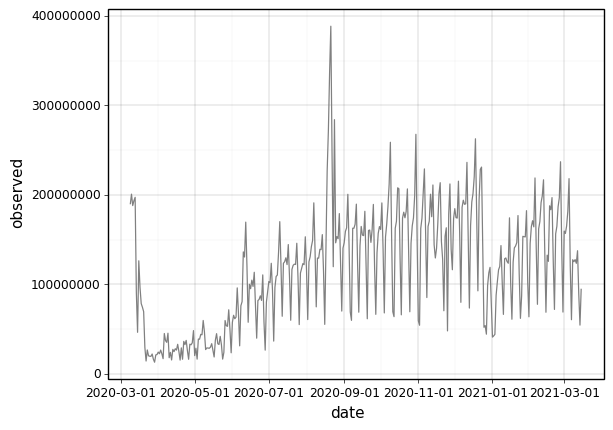

<ggplot: (8772915962809)>

In [216]:
(p9.ggplot(data=df_cty.reset_index(),
           mapping=p9.aes(x='date', y='observed')) 
        + p9.geom_line(color = 'gray'))

2021-03-16 17:16:36.854 | DEBUG    | __main__:_validate_series:15 - ... validating ...
2021-03-16 17:16:36.960 | DEBUG    | __main__:_find_anomalies:50 - Anomalies found: 11
2021-03-16 17:16:36.961 | DEBUG    | __main__:_find_anomalies:51 - (372, 25)
2021-03-16 17:16:36.995 | DEBUG    | __main__:_impute_anomalies:80 - (372, 29)


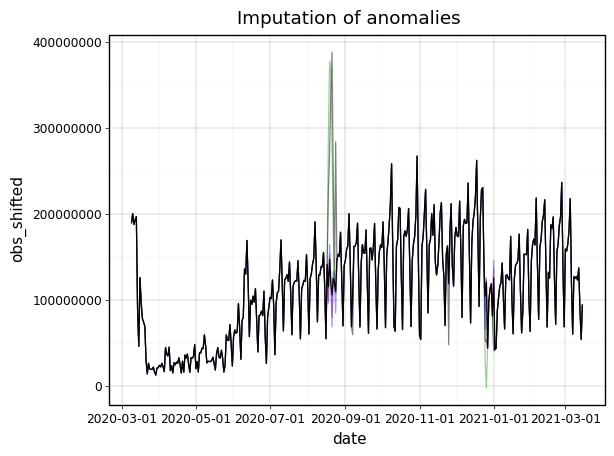

<ggplot: (8772898887729)>


,date,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,year,month,day,dow,observed,expected_2020,ratio_20,tcp,dashboard,region_shapefile_wkt,obs_shifted,anomaly_persist,anomaly_seasonal,anomaly_autor,anomaly_sum,obs_missing,RollingMean,RollingMedian,Polinomial,Loess
0,2020-04-07,2021-03-16 10:52:56.713,saopaulo,São Paulo,Brazil,BR,BR,city,21001688,America/Sao_Paulo,2020,4,7,2,37106752,196747632.0,0.188601,-81.139924,TRUE,Polygon ((-46.75875175979027176 -23.2420841263...,37106752,NaN,NaN,NaN,NaN,37106752.0,37106752.0,37106752.0,37106752.0,37106752
1,2021-02-09,2021-03-16 10:52:56.713,saopaulo,São Paulo,Brazil,BR,BR,city,21001688,America/Sao_Paulo,2021,2,9,2,170090217,196747632.0,0.864510,-13.549040,TRUE,Polygon ((-46.75875175979027176 -23.2420841263...,170090217,NaN,NaN,NaN,NaN,170090217.0,170090217.0,170090217.0,170090217.0,170090217
2,2020-06-02,2021-03-16 10:52:56.713,saopaulo,São Paulo,Brazil,BR,BR,city,21001688,America/Sao_Paulo,2020,6,2,2,65403514,196747632.0,0.332423,-66.757661,TRUE,Polygon ((-46.75875175979027176 -23.2420841263...,65403514,NaN,NaN,NaN,NaN,65403514.0,65403514.0,65403514.0,65403514.0,65403514


In [217]:
df_anomaly = _find_anomalies(df_cty, anomaly_vote_minimun = 1, print_plot=False)
df_impute  = _impute_anomalies(df_anomaly, anomaly_vote_minimun = 1, print_plot=True).reset_index()
df_impute.head(3)

2021-03-16 17:16:45.726 | DEBUG    | __main__:_validate_series:15 - ... validating ...


[<AxesSubplot:>]

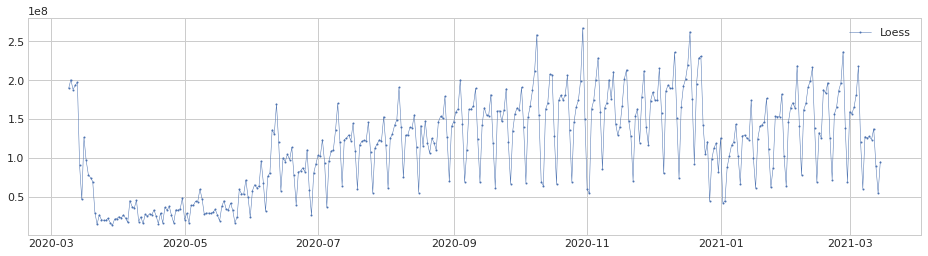

In [219]:
observed_variable = 'Loess'
s = _validate_series(df_impute, column_name='Loess')
plot(s)

In [228]:
c_region = pd.read_csv('/home/soniame/shared/spd-sdv-omitnik-waze/corona/raw/cities_c_iqr.csv') \
    .rename(columns={'city':'region_slug'})
# TODO: maximo de p's
c_param = c_region[c_region.region_slug == region_slug].c_low_p1.to_list()[0]
logger.debug('c_param: ' + str(c_param))
#pd.to_numeric(c_region[c_region.region_slug == region_slug].c_low_p1)
c_region

2021-03-16 17:20:24.556 | DEBUG    | __main__:<module>:4 - c_param: 0.807


,region_slug,iqr,p25,p75,p1,p5,p95,p99,c_low_p1,c_up_p99,c_low_p5,c_up_p95
0,mexicocity,74633936,148636688,223270624,57435256,85817112,263058928,295132352,1.222,0.963,0.842,0.533
1,riodejaneiro,42292816,55101076,97393896,24993406,29207748,113087752,120480592,0.712,0.546,0.612,0.371
2,saopaulo,99504680,124556048,224060736,44300288,60109340,266636080,316160992,0.807,0.926,0.648,0.428


In [221]:
shift_l = list()
# TODO: parameters for length percentage
# min_len = 
for cp in [round(c_param-c_param*(.60), 4), 
           round(c_param-c_param*(.20), 4), 
           c_param, 
           round(c_param+c_param*(.20), 4), 
           round(c_param+c_param*(.60), 4) ]:
    for wdw in [14, 15, 16, 17, 18]:    
        shift = _level_shift_detection(s, c_param = cp,
                                       window_param=wdw, 
                                       print_plot = False) \
                .rename(columns={observed_variable:f'shift_c{cp}_w{wdw}'})
        shift_l.append(shift)
len(shift_l)    
df_shift = reduce(lambda df1, df2: df1.merge(df2, on='date'), shift_l)
df_shift.shape
df_shift.head(3)

2021-03-16 17:16:47.831 | DEBUG    | __main__:_level_shift_detection:20 - ... detecting shift c0.3228-w14...
2021-03-16 17:16:47.853 | DEBUG    | __main__:_level_shift_detection:20 - ... detecting shift c0.3228-w15...
2021-03-16 17:16:47.875 | DEBUG    | __main__:_level_shift_detection:20 - ... detecting shift c0.3228-w16...
2021-03-16 17:16:47.897 | DEBUG    | __main__:_level_shift_detection:20 - ... detecting shift c0.3228-w17...
2021-03-16 17:16:47.918 | DEBUG    | __main__:_level_shift_detection:20 - ... detecting shift c0.3228-w18...
2021-03-16 17:16:47.940 | DEBUG    | __main__:_level_shift_detection:20 - ... detecting shift c0.6456-w14...
2021-03-16 17:16:47.963 | DEBUG    | __main__:_level_shift_detection:20 - ... detecting shift c0.6456-w15...
2021-03-16 17:16:47.988 | DEBUG    | __main__:_level_shift_detection:20 - ... detecting shift c0.6456-w16...
2021-03-16 17:16:48.010 | DEBUG    | __main__:_level_shift_detection:20 - ... detecting shift c0.6456-w17...
2021-03-16 17:16:48

,shift_c0.3228_w14,shift_c0.3228_w15,shift_c0.3228_w16,shift_c0.3228_w17,shift_c0.3228_w18,shift_c0.6456_w14,shift_c0.6456_w15,shift_c0.6456_w16,shift_c0.6456_w17,shift_c0.6456_w18,shift_c0.807_w14,shift_c0.807_w15,shift_c0.807_w16,shift_c0.807_w17,shift_c0.807_w18,shift_c0.9684_w14,shift_c0.9684_w15,shift_c0.9684_w16,shift_c0.9684_w17,shift_c0.9684_w18,shift_c1.2912_w14,shift_c1.2912_w15,shift_c1.2912_w16,shift_c1.2912_w17,shift_c1.2912_w18
date,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


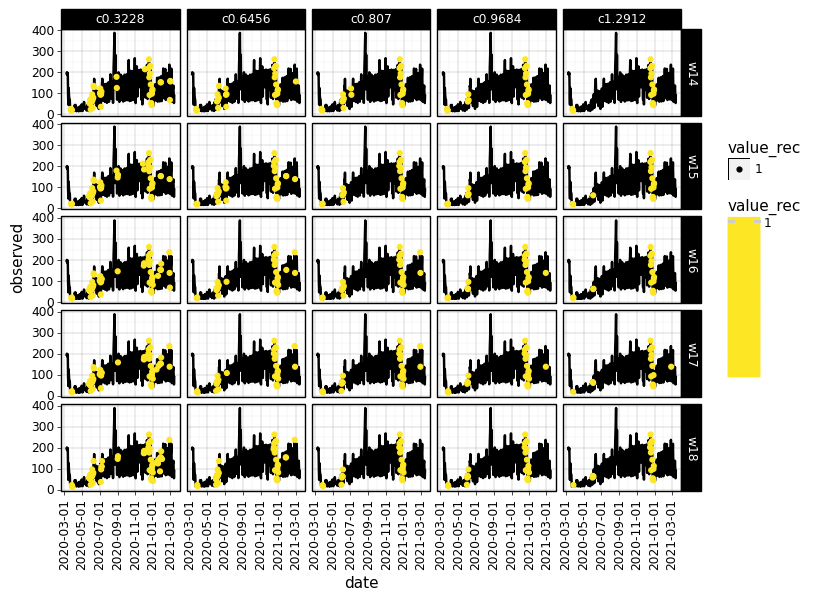

<ggplot: (8772899291305)>

In [222]:

tab = (df_shift.reset_index()
 >> gather('variable', 'value', -_.date)
 >> mutate(value_rec = _.value.replace( 0, np.nan))
 >> left_join(right = df_cty[['date', 'observed', 'dow']], on='date')
 >> mutate(observed = _.observed/1e6)
)
tab[['shift', 'cparam', 'window']] = tab['variable'].str.split('_',expand=True)
(p9.ggplot(tab, p9.aes(x ='date', y = 'observed'))
 + p9.geom_line(size = 1) 
 + p9.geom_point(p9.aes(size = 'value_rec', color = 'value_rec')) 
 + p9.facet_grid('window ~ cparam')
 + p9.scale_size_continuous(range=(1.5, 1.5)) 
 + p9.theme(axis_text_x=p9.element_text(angle=90),
            figure_size=(8, 6) )
)

In [223]:
(df_shift.reset_index()
 >> gather('variable', 'value', -_.date)
 >> filter(_.value == 1)
 >> group_by('variable')
 >> summarize(date_min = _.date.min())
 >> group_by('date_min')
 >> summarize(count = _.date_min.count())
 >> arrange('count')
)

,date_min,count
0,2020-03-23,5
1,2020-03-24,5
2,2020-03-25,5
3,2020-03-26,5
4,2020-03-27,5


In [224]:
df_shift.reset_index().head()
df_shift_sum = (df_shift.reset_index()
 >> gather('variable', 'value', -_.date)
 >> group_by('date')
 >> summarize(shift_sum = _.value.sum())
 >> filter(_.shift_sum > 0)
 >> arrange('date')
)
df_shift_sum
df_shift_sum[df_shift_sum.shift_sum == df_shift_sum.shift_sum.max()]

,date,shift_sum
283,2020-12-17,25.0
284,2020-12-18,25.0
285,2020-12-19,25.0
286,2020-12-20,25.0
287,2020-12-21,25.0
288,2020-12-22,25.0
289,2020-12-23,25.0
290,2020-12-24,25.0
291,2020-12-25,25.0
292,2020-12-26,25.0


In [225]:
shift_init = df_shift_sum[df_shift_sum.shift_sum == df_shift_sum.shift_sum.max()].date.min()
df_sh = df_impute.merge(df_cty)
column_name = 'Loess'
shift_init

Timestamp('2020-12-17 00:00:00')

In [226]:
# a two weeks both sided window
shift_wdw_init = shift_init - timedelta(days=14)
shift_wdw_end  = shift_init + timedelta(days=14)
# level centered
center_point = ((df_sh[(df_sh['date'] >  shift_wdw_init) & 
                    (df_sh['date'] <= shift_init)].observed.mean()) -
                (df_sh[(df_sh['date'] >  shift_init) & 
                    (df_sh['date'] <= shift_wdw_end)].observed.mean())
               )
# change print to logger
logger.debug(center_point)

2021-03-16 17:17:01.068 | DEBUG    | __main__:<module>:11 - 40223038.5


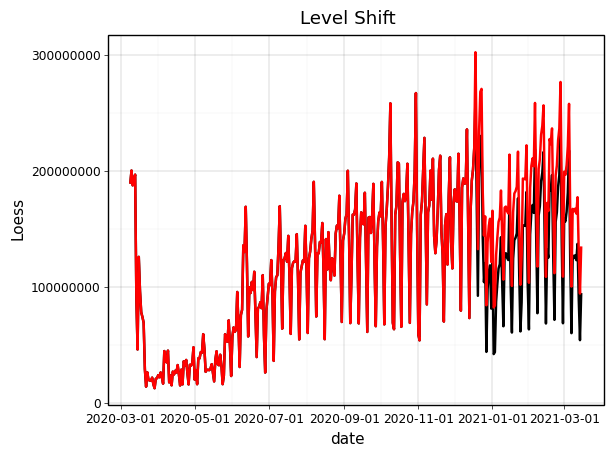

<ggplot: (8772899086385)>

In [227]:
df_sh['obs_shifted'] = df_sh[column_name]
df_sh['obs_shifted'][(df_sh['date'] > shift_init)] = \
    ((df_sh[column_name][(df_sh['date'] > shift_init)]) + 
      center_point)

_plot_levelshift(df_sh, observed_variable)

In [173]:
(df_mx.merge(df_shift_sum, on='date', how='left').siu_filter((_.date >= '2020-07-01') & (_.date <= '2020-07-26'))
 >> p9.ggplot(p9.aes(x='date', y='observed'))
 + p9.geom_line(size = 1) 
 + p9.geom_point(p9.aes(size = 'shift_sum', color ='shift_sum'), alpha = .8)
)

NameError: name 'df_mx' is not defined